In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import import_ipynb

plt.style.use("seaborn-darkgrid")

In [2]:
import Orders, Freights
import Customers, PlantPorts, ProductsPerPlant, WhCapacities, WhCosts

importing Jupyter notebook from Orders.ipynb
importing Jupyter notebook from Freights.ipynb
importing Jupyter notebook from Customers.ipynb
importing Jupyter notebook from PlantPorts.ipynb
importing Jupyter notebook from ProductsPerPlant.ipynb
importing Jupyter notebook from WhCapacities.ipynb
importing Jupyter notebook from WhCosts.ipynb


# 2da Etapa: Optimización

*Función Objetivo*\
Se desea conocer un conjunto de plantas de almacenaje, puertos de origen y puertos de destino que minimicen el costo total de la cadena de suministro.

- q: Cantidad de items en cada pedido [items/pedido]
- w: Peso [kg/item]
- F: Peso máximo [kg/item]
- P: Costo de almacenamiento [USD/item]
- M: Costo fijo de transporte [USD/kg]
- X: Costo de almacenamiento [USD/pedido]
- Y: Costo de transporte [USD/pedido]
- Z: Costo total de la cadena de suministro [USD/pedido]

Subíndices:
- k: ID de pedido
- i: ID de planta de almacenamiento
- p: ID de puerto de origen
- j: ID de puerto de destino
- c: ID de transportista
- s: Nivel de servicio
- t: Tiempo de envío [días]
- m: Modo de transporte (aire o tierra)

### Costos del Almacenamiento



Se deben sumar todos los costos de almacenamiento [USD/pedido] para cada ID Planta.

$$ X_{i} = \sum_{k}{(q_{k}*P_i)} $$

In [3]:
#Fusionamos la tabla Pedidos con la tabla Costos de Almacenamiento usando la función Merge de la librería Pandas.
df1 = Orders.orders[["Planta", "Cantidad [Items/pedido]"]].merge(WhCosts.costs, how = "inner", on = "Planta")

df1["Costo [USD/pedido]"] = df1["Cantidad [Items/pedido]"] * df1["Costo [USD/item]"]

g1 = df1.groupby(by = "Planta").agg({"Costo [USD/pedido]": ["sum"]})
g1.round(2)

,Costo [USD/pedido]
,sum
Planta,
3,14806565.92
4,149.12
8,144835.65
9,104096.86
12,86590.76
13,20375.42


### Capacidad del Almacenamiento

In [4]:
#Hay que fusionar la tabla Pedidos con la tabla Capacidad usando la función Merge de la librería Pandas.
df2 = Orders.orders[["Pedido", "Planta"]].merge(WhCapacities.capacities, how = "inner", on = "Planta")

g2 = df2.groupby(by = "Planta").agg({"Capacidad [pedidos/día]": np.mean})
g2

,Capacidad [pedidos/día]
Planta,
3,1013
4,554
8,14
9,11
12,209
13,490


In [5]:
g2 = df2.groupby(by = "Planta").agg({"Pedido": np.size}).rename(columns = {"Pedido": "Recuento"})

g2

,Recuento
Planta,
3,8541
4,1
8,102
9,12
12,300
13,86


$$ \sum_{k}{o_{ki}} \leq \ C_{i} $$

In [6]:


df2["Recuento de Pedidos"] = df2.groupby(by = ["Planta"])["Pedido"].transform("sum")
df2["Recuento de Pedidos"] = np.where(df2["Recuento de Pedidos"] <= df2["Capacidad [pedidos/día]"], df2["Recuento de Pedidos"], df2["Capacidad [pedidos/día]"])

### Costos de Transporte

In [7]:
#Hay que fusionar la tabla pedidos con las tablas Fletes y Plantas por Puertos usando la función Merge de la librería Pandas.
df3 = pd.merge(Orders.orders, Freights.freights, how = "inner", on = ["Puerto de origen", "Puerto de destino", "Transportista", "Nivel de servicio"])
df3 = pd.merge(df3, PlantPorts.plantports, how = "inner", on = ["Planta", "Puerto de origen"])

g3 = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Tasa de flete [USD/kg]": ["sum"]})
g3.round(2)

,,,Tasa de flete [USD/kg]
,,,sum
Planta,Puerto de origen,Puerto de destino,
3,4,9,21760.83
8,4,9,44.04
9,4,9,5.23
12,4,9,1175.37
13,4,9,37.50


$$ \sum_{k}{w_{kpjcstm}} \leq max \ F_{kpjcstm} $$

In [8]:
df3["Suma de Peso [kg/item]"] = df3.groupby(["Puerto de origen", "Puerto de destino", "Transportista", 
                                             "Nivel de servicio", "Envío [días]", "Modo de transporte"])["Peso [kg/item]"].transform("sum")

df3["Suma de Peso [kg/item]"] = np.where(df3["Suma de Peso [kg/item]"] <= df3["Peso máximo [kg/item]"], df3["Suma de Peso [kg/item]"], df3["Peso máximo [kg/item]"])


g3 = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Suma de Peso [kg/item]": np.mean})
g3.round(2)

,,,Suma de Peso [kg/item]
Planta,Puerto de origen,Puerto de destino,
3,4,9,9346.49
8,4,9,20569.99
9,4,9,20569.99
12,4,9,6861.98
13,4,9,20569.99


$$Y_{kpjcstm} = 
     \begin{cases}
        0 &\quad \text{para, } s = CRF \\
        \frac{w_{kpjcstm}}{\sum_{k}{w_{kpjcstm}}}*R_{kpjcstm}  &\quad \text{para, } s \neq CRF, m = Tierra \\
        w_{kpjcstm}*R_{kpjcstm}  &\quad \text{para, } s \neq CRF, m \neq Tierra \\
        M_{kpjcstm}  &\quad \text{para, }  Y_{kpjcstm} \lt M_{kpjcstm} \\
     \end{cases}
$$

In [9]:
a = df3["Peso [kg/item]"] / df3["Suma de Peso [kg/item]"] * df3["Tasa de flete [USD/kg]"]
b = df3["Peso [kg/item]"] * df3["Tasa de flete [USD/kg]"]
c = df3["Costo mínimo [USD/kg]"]

df3["Costo de transporte [USD/pedido]"] = np.where(df3["Nivel de servicio"] == "CRF", 0, np.where(df3["Modo de transporte"] == "Tierra", np.where(a < c, a, c), np.where(b < c, b, c)))

$$ Y_{pj} = \sum_{cstm}{Y_{pjcstm}} $$

In [10]:
g3 = df3.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Costo de transporte [USD/pedido]": ["sum"]})
g3.round(2)

,,Costo de transporte [USD/pedido]
,,sum
Puerto de origen,Puerto de destino,
4,9,111527.17


### Costos Totales

$$ Z_{ipj} = min \ (X_{i} + Y_{pj}) $$

*¿Qué conjunto Planta, Puerto de origen y Puerto de destino tiene la menor Suma de Costo Total?*

In [ ]:
df4 = pd.merge(g1, g3, how = "cross")

df4["Costo total [USD/pedido]"] = df4["Costo [USD/pedido]"] + df4["Costo de transporte [USD/pedido]"]
df4.index = g1.index

In [12]:
df4.round(2)

,Costo [USD/pedido],Costo de transporte [USD/pedido],Costo total [USD/pedido]
,sum,sum,
Planta,,,
3,14806565.92,111527.17,14918093.09
4,149.12,111527.17,111676.29
8,144835.65,111527.17,256362.83
9,104096.86,111527.17,215624.04
12,86590.76,111527.17,198117.93
13,20375.42,111527.17,131902.59


Text(0, 0.5, 'Costo total [USD/pedido]')

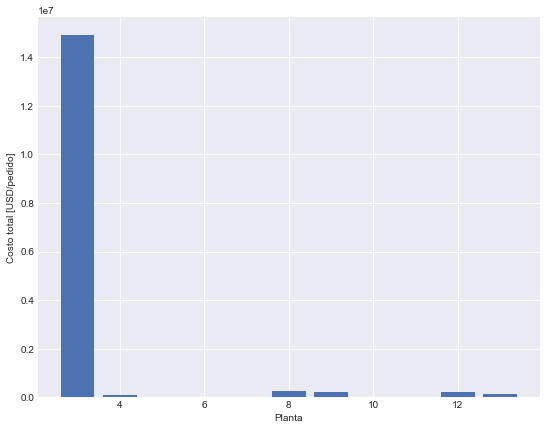

In [13]:
plt.figure(figsize = (9, 7))
plt.bar(df4.index, df4["Costo total [USD/pedido]"])
plt.xlabel("Planta")
plt.ylabel("Costo total [USD/pedido]")

In [14]:
p = df4["Costo total [USD/pedido]"].idxmin()

"Planta de almacenamiento: {}".format(p)

'Planta de almacenamiento: 4'